In [ ]:
#Import different kinds of library
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras import Model, layers
from keras.models import load_model, model_from_json

In [ ]:
import glob
import os
import shutil
from pathlib import Path
import matplotlib.font_manager as fm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#counting the train data of each class
for i in os.listdir("/content/drive/MyDrive/Brain Cancer"):
  try:
    c = len(os.listdir(os.path.join("/content/drive/MyDrive/Brain Cancer",i)))
    print(i+": "+str(c))
  except:
    pass

brain_tumor: 1590
brain_menin: 922


In [ ]:
#Load the dataset
BATCH_SIZE = 32
IMAGE_SIZE = 50
CHANNELS=1
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Brain Cancer',
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2512 files belonging to 2 classes.


In [ ]:
#Class name in the dataset
class_name=dataset.class_names
class_name


['brain_menin', 'brain_tumor']

In [ ]:
#image shape 
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 50, 50, 3)
[1 1 1 0 1 0 1 1 0 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1]


In [ ]:
#printing some data to see all ok or not
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0].numpy())


[[[ 2.         2.         2.       ]
  [ 3.         3.         3.       ]
  [ 3.579997   3.579997   3.579997 ]
  ...
  [19.200012  19.200012  19.200012 ]
  [15.62      15.62      15.62     ]
  [ 0.         0.         0.       ]]

 [[ 2.         2.         2.       ]
  [ 3.8599997  3.8599997  3.8599997]
  [ 2.1400003  2.1400003  2.1400003]
  ...
  [21.114006  21.114006  21.114006 ]
  [ 9.279984   9.279984   9.279984 ]
  [ 2.2400513  2.2400513  2.2400513]]

 [[ 3.         3.         3.       ]
  [ 0.         0.         0.       ]
  [ 3.         3.         3.       ]
  ...
  [15.110014  15.110014  15.110014 ]
  [10.780045  10.780045  10.780045 ]
  [ 0.         0.         0.       ]]

 ...

 [[ 0.         0.         0.       ]
  [ 0.         0.         0.       ]
  [ 0.         0.         0.       ]
  ...
  [ 0.         0.         0.       ]
  [ 0.         0.         0.       ]
  [ 0.         0.         0.       ]]

 [[ 0.         0.         0.       ]
  [ 0.         0.         0.       ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


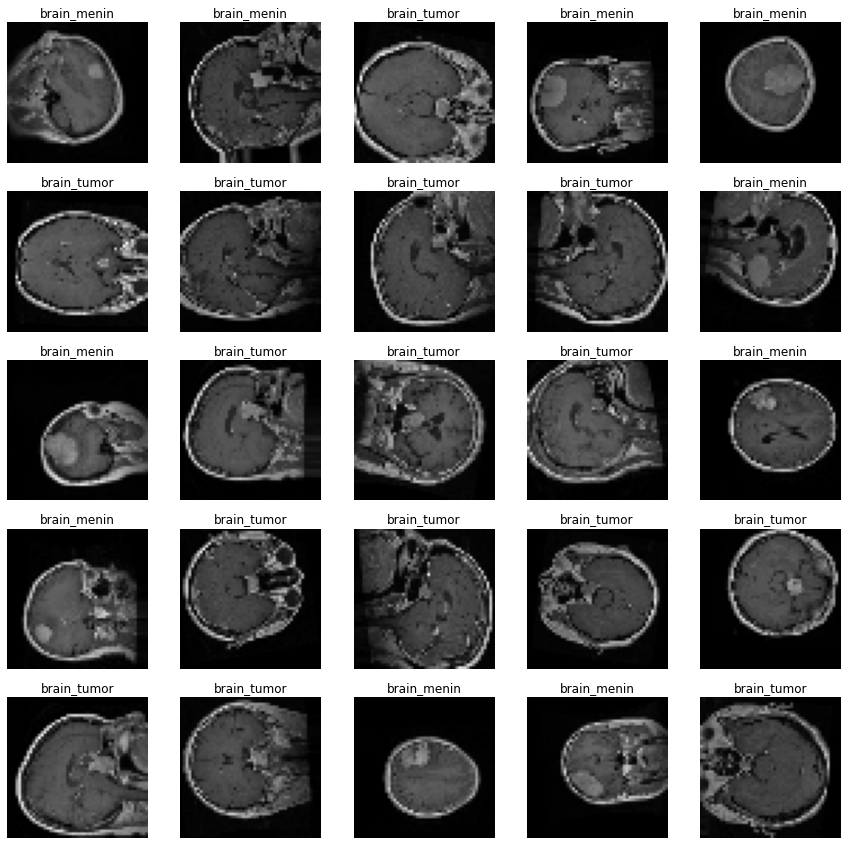

In [ ]:
#some data visualization for understanding
plt.figure(figsize=(15,15))
for image_batch, labels_batch in dataset.take(2):
  for i in range(25):
    ax=plt.subplot(5,5,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_name[labels_batch[i]])
    plt.axis("off")

In [ ]:
#data spliting fuction train = 70%, validation 20% and test =10%
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.2, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Importing the tensorflow.keras for model building
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [ ]:
#Custom Model

conv_base = tf.keras.Sequential([
    layers.Conv2D(64, (3,3), strides=(2,2),padding='same',input_shape= (50,50,3),activation = 'relu'), 
    layers.MaxPool2D(2,2), 
    layers.Conv2D(128, (3,3), strides=(2,2),padding='same',activation = 'relu'),
    layers.MaxPool2D(2,2), 
    layers.Conv2D(256, (3,3), strides=(2,2),padding='same',activation = 'relu'), 
    layers.MaxPool2D(2,2),  
    layers.Flatten(), 


])


x = conv_base.output
x = layers.Dense(128, activation='relu')(x) 
predictions = layers.Dense(3, activation='softmax')(x)
model = Model(conv_base.input, predictions)
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [ ]:
#Train the model
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20
)

Epoch 1/20
55/55 [==============================] - 14s 111ms/step - loss: 1.8492 - accuracy: 0.7222 - val_loss: 0.3692 - val_accuracy: 0.8354
Epoch 2/20
55/55 [==============================] - 0s 6ms/step - loss: 0.3415 - accuracy: 0.8574 - val_loss: 0.3434 - val_accuracy: 0.8521
Epoch 3/20
55/55 [==============================] - 0s 5ms/step - loss: 0.2861 - accuracy: 0.8807 - val_loss: 0.3052 - val_accuracy: 0.8813
Epoch 4/20
55/55 [==============================] - 0s 5ms/step - loss: 0.2374 - accuracy: 0.9017 - val_loss: 0.2237 - val_accuracy: 0.9146
Epoch 5/20
55/55 [==============================] - 0s 5ms/step - loss: 0.1525 - accuracy: 0.9409 - val_loss: 0.2320 - val_accuracy: 0.9083
Epoch 6/20
55/55 [==============================] - 0s 5ms/step - loss: 0.1135 - accuracy: 0.9574 - val_loss: 0.1953 - val_accuracy: 0.9354
Epoch 7/20
55/55 [==============================] - 0s 5ms/step - loss: 0.0990 - accuracy: 0.9597 - val_loss: 0.1982 - val_accuracy: 0.9438
Epoch 8/20
55/55 

In [ ]:
scores = model.evaluate(test_ds)

9/9 [==============================] - 5s 4ms/step - loss: 0.2029 - accuracy: 0.9618


first image to predict
actual label: brain_tumor
1/1 [==============================] - 0s 16ms/step
predicted label: brain_tumor


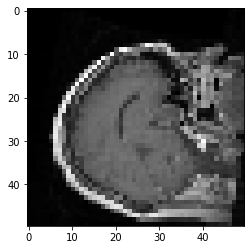

In [ ]:
#predicting a single image from test dataset
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[1].numpy().astype('uint8')
    first_label = labels_batch[1].numpy()
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_name[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_name[np.argmax(batch_prediction[1])])

In [ ]:
#function for prediction
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 16ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


1/1 [==============================] - 0s 16ms/step


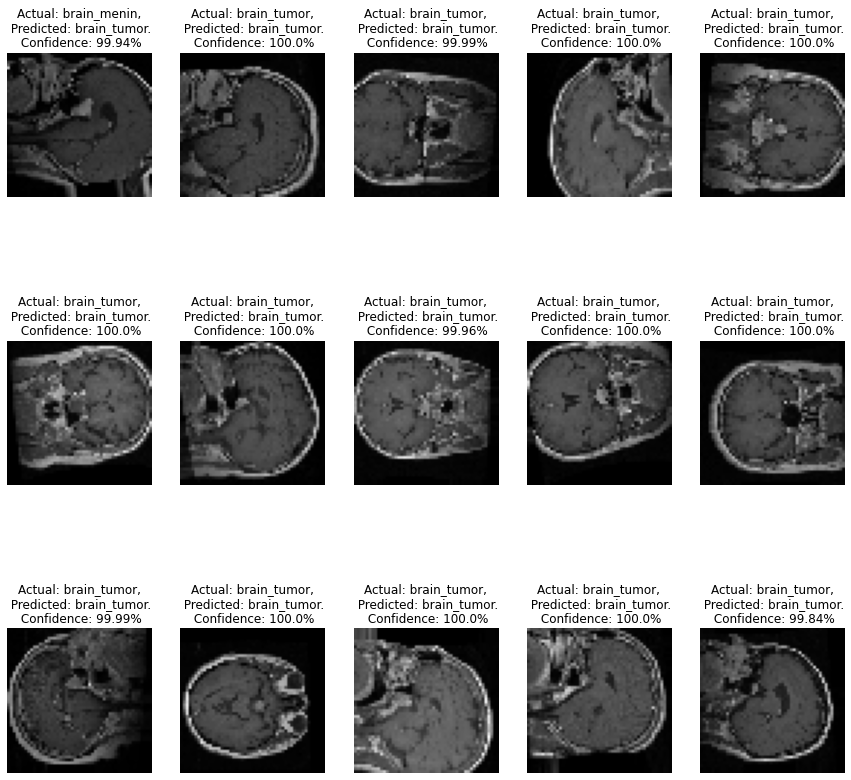

In [ ]:
#comparision of predction and actual class 
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(2):
    for i in range(15):
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence =predict(model, images[i].numpy())
        actual_class = class_name[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

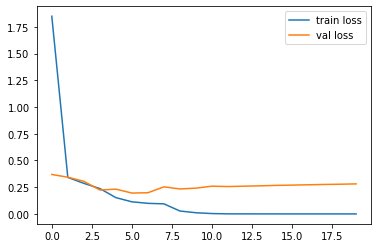

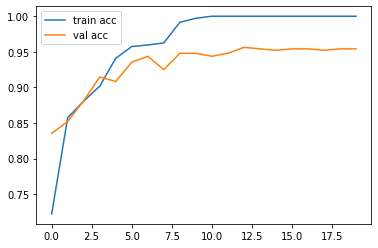

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
predicted = []
actual = []
for images, labels in test_ds:
  for i in range(32):
    try:
      predicted_class, confidence =predict(model, images[i].numpy())
      predicted.append(predicted_class)
      actual.append(class_name[labels[i]])
      # print(predicted_class,class_name[labels[i]])
    except:
      pass

1/1 [==============================] - 0s 16ms/step


In [ ]:
#calculating precision, recall and fscore
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(actual, predicted)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))

precision: [0.93333333 0.97474747]
recall: [0.94382022 0.96984925]
fscore: [0.93854749 0.97229219]


In [ ]:
#creating the confusion matrix
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

con_matrix = confusion_matrix(actual, predicted)
con_matrix

array([[ 84,   5],
       [  6, 193]])

In [ ]:
#ploting cf with better view 
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
  
  import matplotlib.pyplot as plt
  import numpy as np
  import itertools

  accuracy = np.trace(cm) / float(np.sum(cm))
  misclass = 1 - accuracy

  if cmap is None:
      cmap = plt.get_cmap('Blues')

  plt.figure(figsize=(10, 10))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()

  if target_names is not None:
      tick_marks = np.arange(len(target_names))
      plt.xticks(tick_marks, target_names, rotation=45)
      plt.yticks(tick_marks, target_names)

  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  thresh = cm.max() / 1.5 if normalize else cm.max() / 2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      if normalize:
          plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                    horizontalalignment="center",
                    color="black" if cm[i, j] > thresh else "black")
      else:
          plt.text(j, i, "{:,}".format(cm[i, j]),
                    horizontalalignment="center",
                    color="black" if cm[i, j] > thresh else "black")


  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
  plt.show()

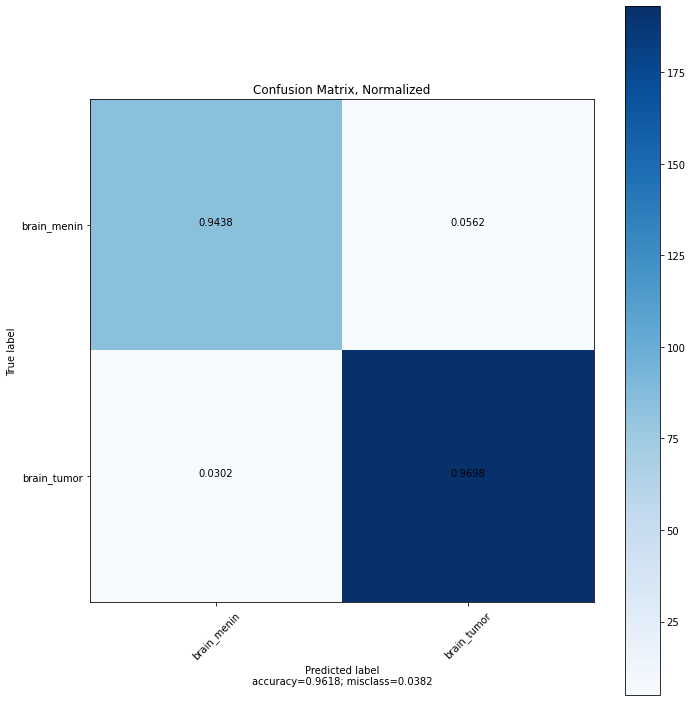

In [ ]:
plot_confusion_matrix(cm           = con_matrix, 
                      normalize    = True,
                      target_names = class_name,
                      title        = "Confusion Matrix, Normalized")

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(actual, predicted, target_names=class_name))

              precision    recall  f1-score   support

 brain_menin       0.93      0.94      0.94        89
 brain_tumor       0.97      0.97      0.97       199

    accuracy                           0.96       288
   macro avg       0.95      0.96      0.96       288
weighted avg       0.96      0.96      0.96       288

